# Import a SageMaker Predictive Model for Calculating Risk Index per Region - 

In [1]:
import time
st = time.time()

### Install necessary libraries

In [2]:
!pip install pandas_profiling
!pip install lightgbm
!pip install shap

### Import the libraries into the notebook

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import ipaddress
import pandas_profiling as pp
%matplotlib inline
from sklearn import preprocessing
plt.rc("font", size=14)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
import time
import boto3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import shap
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

### Update the S3 credentials in the below cell.
We will ingest the data files which were pre-processed in the earlier steps using the Data pre-processing Notebook

In [4]:
BUCKET_TYPE="s3"
S3_BUCKET_NAME=""
S3_BUCKET_REGION="us-east-2"
SAGEMAKER_ACCESS_KEY_ID=""
SAGEMAKER_SECRET_ACCESS_KEY=""

### Create an instance with S3 Credentials 

In [5]:
s3 = boto3.resource(
    service_name = BUCKET_TYPE,
    region_name = S3_BUCKET_REGION,
    aws_access_key_id = SAGEMAKER_ACCESS_KEY_ID,
    aws_secret_access_key = SAGEMAKER_SECRET_ACCESS_KEY
)

### Read and display the available datasets in S3 Bucket

In [6]:
datasets = []
for obj in s3.Bucket(S3_BUCKET_NAME).objects.all():
    datasets.append(obj.key)
datasets

['15-day-pred.csv',
 'Belgium-country-output.csv',
 'Belgium-ts.csv',
 'Data-region-RI-SM.csv',
 'Risk-Index-Output/',
 'Risk-Index_data/',
 'Risk-Index_data/Data-region-RI-SM-Scoring.csv',
 'Risk-Index_data/Data-region-RI-SM.csv',
 'Risk-Index_data/Data-region-RI.csv',
 'Risk-Index_data/RI_data.csv',
 'Risk-Index_data/test.csv',
 'Risk-Index_data/train.csv',
 'Risk-Index_data/ts-data-region-RI.csv',
 'Risk_Index/Risk_index_training_recoded.csv',
 'flanders-output.csv',
 'my_pred_model_Belgium.h5',
 'my_pred_model_Flanders.h5',
 'pred-data-15.csv',
 'pred-data.csv',
 'pred-models/',
 'raw-data/',
 'raw-data/COVID19BE_CASES_AGESEX.csv',
 'raw-data/COVID19BE_HOSP.csv',
 'test-data.csv',
 'test-y-data.csv',
 'time-series-data/',
 'time-series-data/formatted/',
 'time-series-data/formatted/Belgium-ts.csv',
 'time-series-data/formatted/forecast-data-15.csv',
 'time-series-data/formatted/results/',
 'time-series-data/formatted/ts-Brussels-grouped.csv',
 'time-series-data/formatted/ts-Brussel

### Read the Risk Index per Region data as dataframe and display five records

In [7]:
obj = s3.Bucket(S3_BUCKET_NAME).Object('ts-data-region-RI.csv').get()
data = pd.read_csv(obj['Body'])
data.head()

DATE    REGION  Total_cases  Risk_Index
0  2020-03-15  Brussels          119           0
1  2020-03-15  Flanders          461           2
2  2020-03-15  Wallonia          383           1
3  2020-03-16  Brussels          238           0
4  2020-03-16  Flanders          794           2

### identify the Data Types

In [8]:
data.dtypes

DATE           object
REGION         object
Total_cases     int64
Risk_Index      int64
dtype: object

### Drop the Date attribute as we will not be using it

In [9]:
data.drop('DATE', axis=1, inplace=True)
data

REGION  Total_cases  Risk_Index
0     Brussels          119           0
1     Flanders          461           2
2     Wallonia          383           1
3     Brussels          238           0
4     Flanders          794           2
...        ...          ...         ...
2215  Brussels          677           0
2216  Flanders         7909           2
2217  Wallonia         1371           1
2218  Flanders          295           2
2219  Wallonia           33           0

[2220 rows x 3 columns]

### Encode the Region data into integers

Brussels is encoded as 0 ::: Flanders is encoded as 1 ::: Wallonia is encoded as 2

In [10]:
label_encoder = preprocessing.LabelEncoder()

data['REGION']= label_encoder.fit_transform(data['REGION'])

data

REGION  Total_cases  Risk_Index
0          0          119           0
1          1          461           2
2          2          383           1
3          0          238           0
4          1          794           2
...      ...          ...         ...
2215       0          677           0
2216       1         7909           2
2217       2         1371           1
2218       1          295           2
2219       2           33           0

[2220 rows x 3 columns]

### Generate the detailed analysis report

In [11]:
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Drop the duplicate values

In [12]:
data.drop_duplicates(keep=False, inplace=True)

In [13]:
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Check for missing values

In [14]:
data.isna()

REGION  Total_cases  Risk_Index
0      False        False       False
1      False        False       False
3      False        False       False
4      False        False       False
5      False        False       False
...      ...          ...         ...
2214   False        False       False
2215   False        False       False
2216   False        False       False
2217   False        False       False
2219   False        False       False

[1898 rows x 3 columns]

### Set the Input & Target variables for the Predictive Model

Region & Total_cases are Input attributes, Risk_Index will be the Target attribute

In [15]:
X = data[data.columns[0:2]]
y = data[data.columns[2:]]

### Print the Input attributes

In [16]:
X

REGION  Total_cases
0          0          119
1          1          461
3          0          238
4          1          794
5          2          568
...      ...          ...
2214       2         2750
2215       0          677
2216       1         7909
2217       2         1371
2219       2           33

[1898 rows x 2 columns]

### Print the Target attribute

In [17]:
y

Risk_Index
0              0
1              2
3              0
4              2
5              1
...          ...
2214           1
2215           0
2216           2
2217           1
2219           0

[1898 rows x 1 columns]

### Split the data using 70:30 mix into Training & Testing samples 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Check for data shape of Training & Testing samples

In [19]:
print("Train_x Shape :: ", X_train.shape)
print("Train_y Shape :: ", y_train.shape)
print("Test_x Shape :: ", X_test.shape)
print("Test_y Shape :: ", y_test.shape)

Train_x Shape ::  (1518, 2)
Train_y Shape ::  (1518, 1)
Test_x Shape ::  (380, 2)
Test_y Shape ::  (380, 1)


### Prepare the dataset for building the Predictive Model

In [20]:
d_train = lgb.Dataset(X_train, label=y_train)

### Build the Model using Light Gradient Boosting algorithm

In [21]:
def LGBM_classifier(features, target):
    """
    To train the LGBM classifier with features and target data
    :param features:
    :param target:
    :return: trained LGBM classifier
    """
    model = LGBMClassifier(metric='multi_logloss', objective='multiclass', num_leaves=60, max_depth=30, min_data=50)
    model.fit(features, target)
    return model

start = time.time()
trained_model = LGBM_classifier(X_train, y_train.values.ravel())
print("> Completion Time : ", time.time() - start)
print("Trained LGBM model :: ", trained_model)
predictions = trained_model.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=50. Current value: min_data_in_leaf=50
> Completion Time :  0.2133326530456543
Trained LGBM model ::  LGBMClassifier(max_depth=30, metric='multi_logloss', min_data=50, num_leaves=60,
               objective='multiclass')


In [22]:
X_test

REGION  Total_cases
995        1         2609
795        2         1668
1627       0          874
97         1         3708
1714       0          565
...      ...          ...
2022       2        19801
1054       0          750
1580       1         1825
1299       2         1470
1010       1         2716

[380 rows x 2 columns]

### Evaluate the accuracy of the Model

In [23]:
print("Train Accuracy :: ", accuracy_score(y_train, trained_model.predict(X_train)))
print("LGBM Model Test Accuracy is :: ", accuracy_score(y_test, predictions))

Train Accuracy ::  0.8616600790513834
LGBM Model Test Accuracy is ::  0.8447368421052631


### Analyze the Confusion Matrix

In [24]:
print(" Confusion matrix ", confusion_matrix(y_test, predictions))

 Confusion matrix  [[101  10   0]
 [ 22  96  16]
 [  1  10 124]]


### Analyze the model performance across different categories

In [25]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       111
           1       0.83      0.72      0.77       134
           2       0.89      0.92      0.90       135

    accuracy                           0.84       380
   macro avg       0.84      0.85      0.84       380
weighted avg       0.84      0.84      0.84       380



### Identify the important feature/s

<AxesSubplot:>

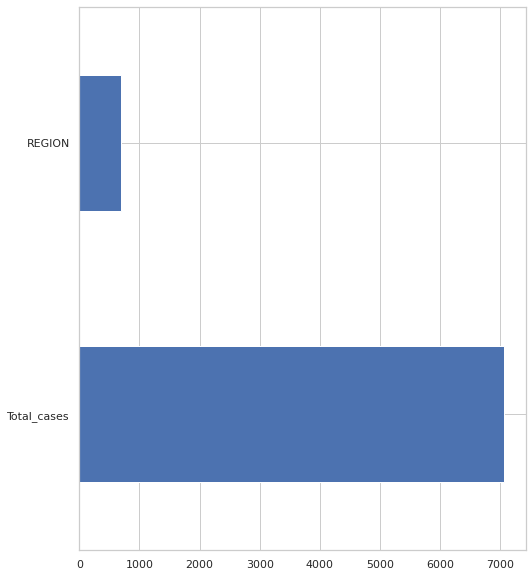

In [26]:
feat_imp = pd.Series(trained_model.feature_importances_, index=X.columns)
feat_imp.nlargest(12).plot(kind='barh', figsize=(8,10))

### Install the shap library for Model Evaluation & Feature Importance

In [27]:
!pip install shap

In [28]:
shap.initjs()

### You may need higher computation resources to run the below cells. 

In [29]:
#shap_values = shap.TreeExplainer(trained_model.booster_).shap_values(X_train)
shap_values = shap.TreeExplainer(trained_model).shap_values(X_train)

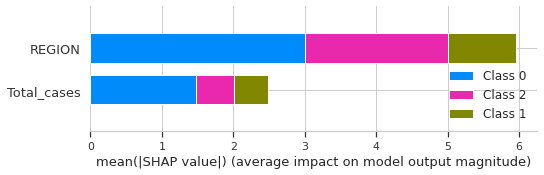

In [30]:
shap.summary_plot(shap_values, X_train)

#### As per above summary plot, we can infer that Region is important/significant attribute for classes 0 & 2 (Brussels & Wallonia) & Total_cases is a significant attribute for class 0 (Brussels) Risk Index prediction. For Flanders (Class 1), Region attribute is more significant than Total_cases to predict Risk Index.

### Let's churn out some predictions using random values for Region & Total_cases 

Risk-Index of 0 is Low ::: Risk-Index of 1 is Moderate ::: Risk-Index of 2 is High Risk

In [31]:
import numpy as np

new_data=np.array([1,1000])
new_data = new_data.reshape(1, -1)

In [32]:
trained_model.predict(new_data)

array([2])

For the input [1, 1000] which is Flanders with 1000 cases per day, the predicted Risk index is ([ 2 ]) which is High risk.

In [33]:
new_data1=np.array([0,10])
new_data1 = new_data1.reshape(1, -1)

In [34]:
trained_model.predict(new_data1)

array([0])

For the input [0, 10] which is Brussels with 10 cases per day, the predicted Risk index is ([ 0 ]) which is Low risk.

In [35]:
new_data2=np.array([2,100])
new_data2=new_data2.reshape(1, -1)

In [36]:
trained_model.predict(new_data2)

array([0])

For the input [2, 1] which is Wallonia with 1 case per day, the predicted Risk index is ([ 1 ]) which is Moderate risk.

### Generate predictions for multiple values in one go

In [37]:
validation_data=np.array([1,500,2,100,0,600])
val_data1 = validation_data.reshape(3, -1)

In [38]:
val_data1

array([[  1, 500],
       [  2, 100],
       [  0, 600]])

In [39]:
trained_model.predict(val_data1)

array([2, 0, 0])

The predicted results are High risk, Moderate risk & Low risk for the three records.

## In this notebook, we have learnt how to build predictive model using SageMaker.

In [40]:
time_taken=round(time.time() - st,1)
print("The Notebook ran in {} ".format(float(time_taken)) + "seconds") 

The Notebook ran in 26.5 seconds
